In [15]:
import pandas as pd
import io

In [16]:
data = pd.read_csv(r'Uploads/data.csv')

In [17]:
buffer = io.StringIO()
data.info(buf=buffer)
df_info_str = buffer.getvalue()

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

In [35]:
from pydantic import BaseModel, Field
from typing import TypedDict, Optional, Annotated, List
from pprint import pprint
import sys
import io
import traceback
import subprocess
from contextlib import redirect_stdout, redirect_stderr

In [3]:
from langchain.chat_models import init_chat_model
from langchain.prompts import ChatMessagePromptTemplate, PromptTemplate

In [178]:
OPENAI = init_chat_model(model='gpt-4o-mini',model_provider='openai')
GROQ = init_chat_model(model='llama-3.3-70b-versatile', model_provider='groq')
llm = GROQ

In [179]:
class Python_Code(BaseModel):
    code: str

In [180]:
def execute_python_code(code):
    PACKAGE_MAPPING = {
        "sklearn": "scikit-learn",
        "cv2": "opencv-python",
        "PIL": "Pillow",
        "yaml": "pyyaml",
        "bs4": "beautifulsoup4",
        "tf": "tensorflow"
    }
    output = io.StringIO()
    error = io.StringIO()

    try:
        with redirect_stdout(output), redirect_stderr(error):
            globals_dict = {}
            exec(code, globals_dict)
        return output.getvalue(), error.getvalue(), None, globals_dict
    except ImportError as e:
        package_name = str(e).split("'")[1]
        pip_package_name = PACKAGE_MAPPING.get(package_name, package_name)
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pip_package_name])
            return execute_python_code(code)
        except subprocess.CalledProcessError:
            return output.getvalue(), error.getvalue(), f"Failed to install package: {pip_package_name}"
    except Exception:
        return output.getvalue(), error.getvalue(), traceback.format_exc(), globals_dict

In [181]:
template = """You are a Ml Engineer, 
            ROLE : To generate a error-free correct python codes to solve the ML task : {tasks} assigned to you
            DATA_PATH = 'uploads/data.csv' 
            INFO_DATA: {info_data}
            INSTRUCTIONS: always write the code inside the function i.e def ml_task()
            and  return the ml cocmpupted dataframe(where you performed the ML task) in the df variable
            also return the plots[] in a list where it contains every fig variables
            example:
            def ml_task():
            # your logic
            return df,plots

            # Make them global
            
            df,plots = ml_task()  # This will be captured by globals_dict inside exec()
           
            avoid using plot.show()
"""
code_prompt = PromptTemplate(
            template = template,
            input_variables = ['tasks','info_data']
            )

In [182]:
ml_llm = code_prompt | llm.with_structured_output(Python_Code)

In [183]:
output = ml_llm.invoke({'tasks':'Do Customer Segmentation','info_data':df_info_str})

In [184]:
code = output.code

In [185]:
pprint(code)

('import pandas as pd\n'
 'import matplotlib.pyplot as plt\n'
 'from sklearn.preprocessing import LabelEncoder\n'
 'from sklearn.cluster import KMeans\n'
 'from sklearn.metrics import silhouette_score\n'
 'import numpy as np\n'
 '\n'
 'def ml_task():\n'
 '    # Load the data\n'
 "    df = pd.read_csv('uploads/data.csv')\n"
 '    \n'
 "    # Encode the categorical variable 'Gender'\n"
 '    le = LabelEncoder()\n'
 "    df['Gender'] = le.fit_transform(df['Gender'])\n"
 '    \n'
 '    # Define the features for clustering\n'
 "    features = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]\n"
 '    \n'
 '    # Perform K-means clustering with different numbers of clusters\n'
 '    silhouette_scores = {}\n'
 '    for n_clusters in range(2, 11):\n'
 '        kmeans = KMeans(n_clusters=n_clusters)\n'
 '        cluster_labels = kmeans.fit_predict(features)\n'
 '        silhouette_avg = silhouette_score(features, cluster_labels)\n'
 '        silhouette_scores[n_clusters] = silhouette_

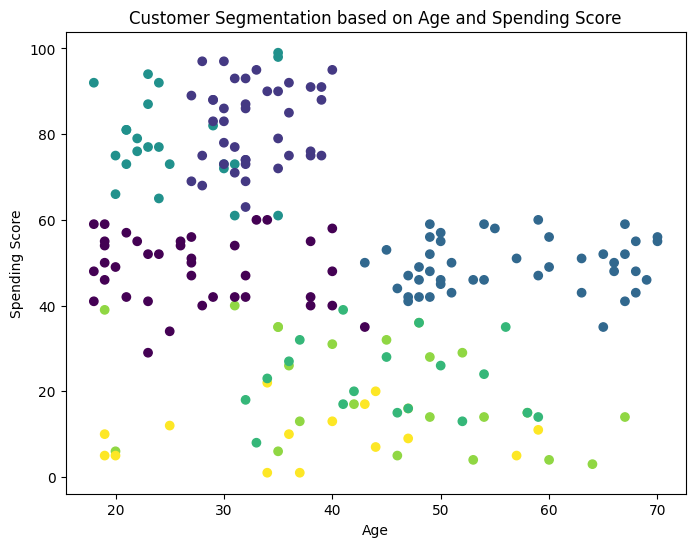

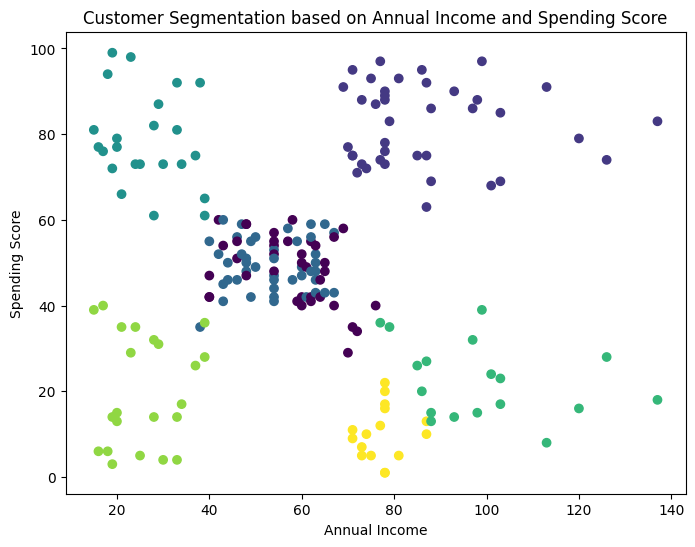

In [186]:
p,e,t,d= execute_python_code(code)

In [187]:
d.get('df')

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,1,19,15,39,5
1,2,1,21,15,81,3
2,3,0,20,16,6,5
3,4,0,23,16,77,3
4,5,0,31,17,40,5
...,...,...,...,...,...,...
195,196,0,35,120,79,1
196,197,0,45,126,28,4
197,198,1,32,126,74,1
198,199,1,32,137,18,4


In [147]:
fun = d.get('ml_task')

c:\Users\navab\miniconda3\envs\generativeai\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\navab\miniconda3\envs\generativeai\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\navab\miniconda3\envs\generativeai\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\navab\miniconda3\envs\generativeai\lib\site-packages\sklearn\cluster\_

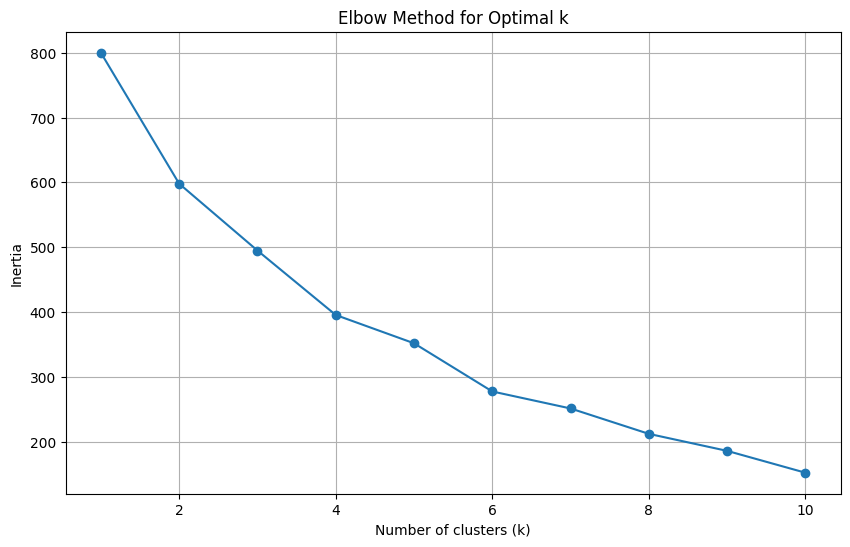

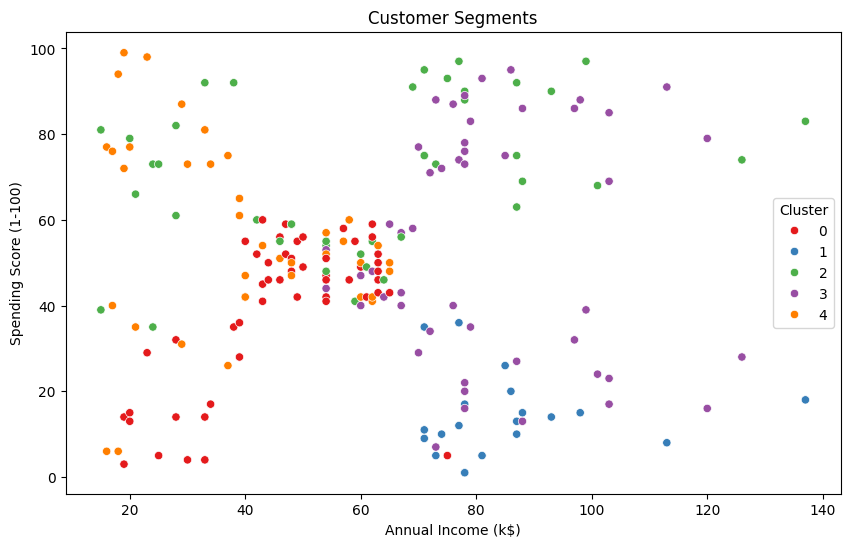

In [135]:
df,figs = fun()

In [189]:
len(figs)

2